# Проект модуля: временные ряды.

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики RMSE на тестовой выборке должно быть не больше 48.

## План проекта:

<a href='#section1'>1. Загрузка и ресемплирование.</a>

<a href='#section2'>2. Анализ Данных.</a>

<a href='#section3'>3. Обучение моделей.</a>

<a href='#section4'>4. Тестирование моделей.</a>

<a href='#section5'>5. Вывод.</a>

<a id='section1'></a>

## 1.Загрузите данные и выполните их ресемплирование по одному часу.

In [1]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

taxi_df = pd.read_csv('taxi.csv', index_col=[0], parse_dates=[0])
taxi_df.sort_index(inplace=True)

print(taxi_df.info())

taxi_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB
None


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


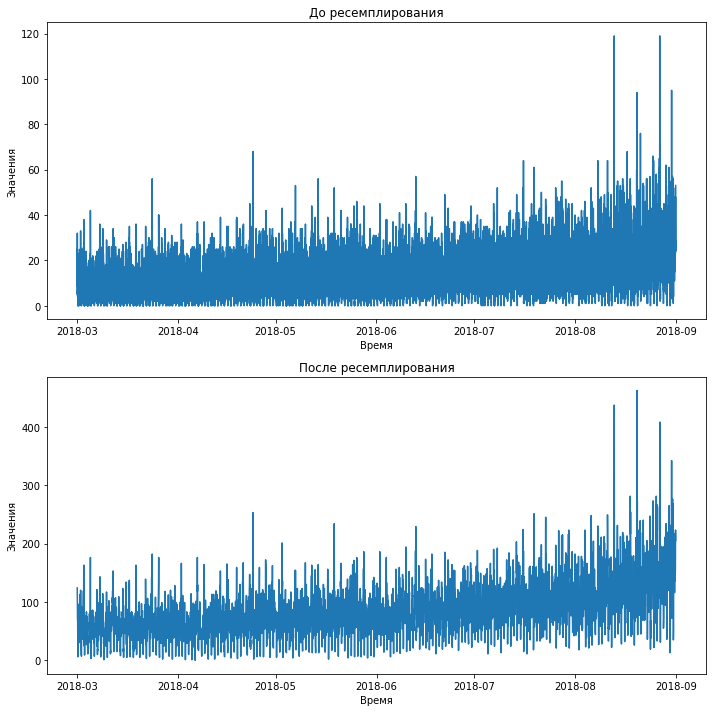

In [2]:
figure, axes = plt.subplots(nrows=2, ncols=1, figsize=(10,10))

axes[0].plot(taxi_df)
axes[0].set_title('До ресемплирования')
axes[0].set_xlabel('Время')
axes[0].set_ylabel('Значения')

taxi_df = taxi_df.resample('1H').sum()
axes[1].plot(taxi_df)
axes[1].set_title('После ресемплирования')
axes[1].set_xlabel('Время')
axes[1].set_ylabel('Значения')

figure.tight_layout()

Отобразили график исходного временного ряда до и после ресемплирования. Особых отличий нет, лишь заметно, что значений стало меньше.

Загрузили датасет и сразу преобразовали столбец с датой в нужный тип и сделали его индексом. Отсортировали по датам и произвели ресемплирование в 1 час.

<a id='section2'></a>

## 2. Проанализируем данные.

Сперва, разобьем наш временной ряд на две составляющие: тренд и сезонность.

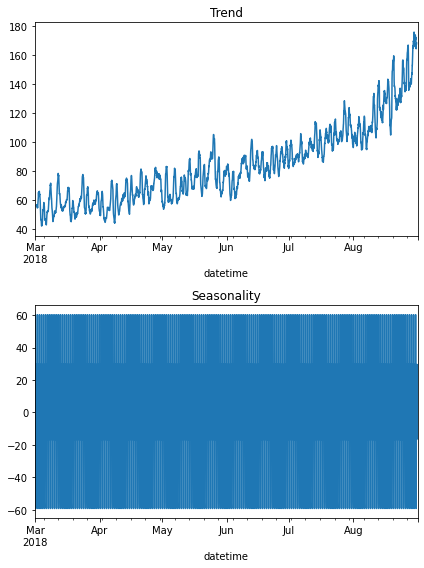

In [3]:
decomposed = seasonal_decompose(taxi_df)

plt.figure(figsize=(6, 8))
plt.subplot(211)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

plt.subplot(212)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.tight_layout()

Из верхних графиков можно сделать два вывода:

- наш временной ряд нестационарен (среднее изменяется во времени)
- график сезонности слишком плотный, надо рассмотреть лишь часть его

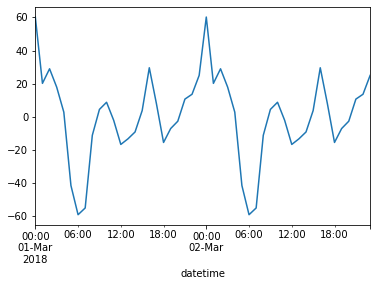

In [4]:
#Взяли двое суток
decomposed.seasonal['2018-03-01':'2018-03-02'].plot()

plt.show()

Меньше всего заказов рано утром. Все еще спят или только просыпаются. Дальше идет резкий всплеск, ведь людям пора на работу. Наибольший всплеск после 18.00. Скорее всего это из-за того, что все возвращаются с работы. Данный рост продолжается и до полуночи; видимо большая часть клиентов это ответственные гуляки, которые не садятся за руль в нетрезвом виде.

Теперь займемся избавлением от нестационарности. Для этого найдем разности значений временного ряда.

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера:</b> 
    
Есть явный тренд на увеличение числа заказов. Также наблюдается сезонность с периодом в один день: в районе 6 утра число заказов минимально, а больше всего заказов ближе к полуночи. Замечу, что речь идет о числе заказов такси **в аэропортах**, а не в целом по городу. 

</div>

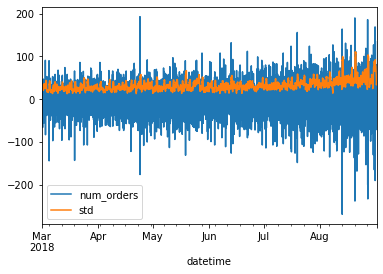

In [5]:
#Посмотрим как ряд будет выглядеть, если сделать его более стационарным
taxi_df_stationary = taxi_df - taxi_df.shift()
taxi_df_stationary['std'] = taxi_df.rolling(15).std()
taxi_df_stationary.plot()

plt.show()

Временной ряд стал явно более стационарным (среднее постоянно), однако, обучать модели и тестировать будем на исходном датасете.

Избавимся от пропусков.

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера:</b> 
    
По заданию требовалось прогнозировать значения **исходного ряда**, а не ряда из первых разностей. Поэтому в последней части задания, при проверке на тестовой выборке следует сначала вычислить предсказания значений **исходного ряда**, после чего вычислить RMSE (чтобы сравнить его с требуемым порогом 48).
</div>

<a id='section3'></a>

## 3. Обучим разные модели.

Напишем функцию, которая создаст дополнительные признаки для модели: 

- календарные признаки
- временной сдвиг
- скользящее среднее

Данная функция после создания признаков удаляет целевой. Это нужно для определения оптимальных значений далее при оубчении Линейно Регрессии. Далее я перепишу ее.

In [3]:
def make_features(data, max_lag, rolling_mean_size, drop_target=True):
    data = data.copy()
    data['year'] = data.index.year
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift(1).rolling(rolling_mean_size).mean()
    
    if drop_target:
        data = data.drop('num_orders',axis=1)
    
    return data

Проверим как она работает

In [7]:
taxi_df_new = make_features(taxi_df,4,4, drop_target=False)
taxi_df_new

,num_orders,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,rolling_mean
datetime,,,,,,,,,,
2018-03-01 00:00:00,124,2018,3,1,3,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,2018,3,1,3,124.0,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,2018,3,1,3,85.0,124.0,NaN,NaN,NaN
2018-03-01 03:00:00,66,2018,3,1,3,71.0,85.0,124.0,NaN,NaN
2018-03-01 04:00:00,43,2018,3,1,3,66.0,71.0,85.0,124.0,86.50
...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,2018,8,31,4,207.0,217.0,197.0,116.0,184.25
2018-08-31 20:00:00,154,2018,8,31,4,136.0,207.0,217.0,197.0,189.25
2018-08-31 21:00:00,159,2018,8,31,4,154.0,136.0,207.0,217.0,178.50


Работает. Когда займемся подбором наилучшей модели, воспользуемся данной функцией, чтобы подобрать наилучший набор признаков.

По классике начнем с Линейной Регрессии. Переберем все возможные комбинации признаков и для каждого обучим модель, которую оценим через кросс-валидацию

In [8]:
train, test = train_test_split(taxi_df, shuffle=False, test_size=0.1)
#Проверка
print(train.index.max(), test.index.min())
train_features = train
traint_target  = train['num_orders']

k = 0
tscv = TimeSeriesSplit(n_splits=3)
scores = {}
for tr_index, val_index in tscv.split(train_features):
    train_features = train_features.reset_index()
    X_tr, X_val = train_features.iloc[tr_index,:], train_features.iloc[val_index,:]
    y_tr, y_val = traint_target.iloc[tr_index], traint_target.iloc[val_index]
    X_tr = X_tr.set_index('datetime')
    X_val = X_val.set_index('datetime')
    for i in np.arange(20,60,2):
        for j in np.arange(20,60,2):
            model = LinearRegression()
            X_train = make_features(X_tr,i,j)
            X_train.dropna(inplace=True)
            y_train = y_tr.loc[X_train.index]
            X_valid = make_features(X_val,i,j)
            X_valid.dropna(inplace=True)
            y_valid = y_val.loc[X_valid.index]
            model.fit(X_train,y_train)
            pred = model.predict(X_valid)
            scores[str(k) + ' ' + str(i) + ' ' + str(j)] = np.sqrt(mean_squared_error(y_valid,pred))
            
    k += 1
    
scores_averaged = {}
for key in scores:
    key_arr = key.split()
    av_score = 0
    for i in range(3):
        av_score += scores[str(i) + ' ' + key_arr[1] + ' ' + key_arr[2]]
    scores_averaged[key_arr[1] + ' ' + key_arr[2]] = av_score / 3

best_features = min(scores_averaged, key=scores_averaged.get)
print('max_lag = {}, rolling_mean_size = {}, RMSE = {:.2f}'.format(best_features.split()[0], \
                                                best_features.split()[1] ,scores_averaged[best_features]))

2018-08-13 13:00:00 2018-08-13 14:00:00
max_lag = 48, rolling_mean_size = 46, RMSE = 25.28


Я тут немного извратился, так как для данной функции нужны были числовые индексы, а не дата, поэтому в циклах я постоянно меняю индексы и немного изменил исходную функцию make_features. Посколько я вызываю ее на датасете, который содержит только признаки, то мне пришлось не удалять целевой признак из train_features, чтобы создавались признаки lag. В конечно итоге я, конечно же, избавляюсь от целевого признака перед обучением модели.

<div class="alert alert-block alert-warning">
<b>Комментарий ревьюера v2:</b>    
Почему пропуски заполняются значением «-1»? Их лучше удалить.
</div>

<div class="alert alert-block alert-danger">
<b>Комментарий ревьюера v2:</b>   
    
Два полученных score на валидационной выборке (так как tscv=TimeSeriesSplit(n_splits=**3**), значит, число валидационных выборок будет 3-1=2) при каждом фиксированном max_lag и rolling_mean_size нужно **усреднить**. Ведь при проведении обычной кросс-валидации значения score на валидационной выборке тоже **усредняются** по всем разбиениям. Замечание относится и к экспериментам ниже.
</div>

В результате мы подобрали наилучший набор признаков (для Линейной Регрессии). На первый взгляд Линейная Регрессия уже дает желаемый результат. Сначала подберем другие модели, а потом проверим их лучшие вариации на тестовой выборке.

Попробуем Случайный Лес. 

In [9]:
train_final = make_features(train,48,46, drop_target=False)
train_final.dropna(inplace=True)
features = train_final.drop('num_orders',axis=1)
# features = features.reset_index()
# features = features.drop('datetime',axis=1)
target = train_final['num_orders']

Подберем наилучшие гиперпараметры Случайного Леса для нашего обновленного датасета.

In [11]:
param_grid = {
    'n_estimators': np.arange(30,100,10),
    'max_depth': np.arange(4,12,2),
    'min_samples_split': np.arange(2,14,4)
}

model      = RandomForestRegressor(random_state=42)
rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(features, target)
print(np.sqrt(-rnd_search.best_score_))
rnd_search.best_estimator_

26.255780727694177


RandomForestRegressor(max_depth=10, min_samples_split=6, n_estimators=60,
                      random_state=42)

<div class="alert alert-block alert-success">
<b>Комментарий ревьюера v2:</b>    
Можно не вручную подбирать параметры, а пользоваться стандартными функциями GridSearchCV и RandomizedSearchCV. В качестве аргумента cv передавать tscv: GridSearchCV(..., cv=tscv) и RandomizedSearchCV(..., cv=tscv).
</div>

Наилучший Случайный Лес нашли. 

Теперь попробуем SVR. Будем варьировать 2 гиперпараметра: kernel, gamma. 

In [ ]:
param_grid = {
    'kernel': ['rbf'],
    'C': np.arange(100,1000,200)
}

model      = SVR()
rnd_search = RandomizedSearchCV(model, param_distributions=param_grid,
                                n_iter=10, cv=tscv, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(features, target)
print(np.sqrt(-rnd_search.best_score_))
rnd_search.best_estimator_

<a id='section4'></a>

## 3. Проверим финальные модели на тестовой выборке.

Начнем с Линейной Регрессии.

In [4]:
taxi_df_final = make_features(taxi_df,48,46,drop_target=False)
taxi_df_final.dropna(inplace=True)
features = taxi_df_final.drop('num_orders',axis=1)
target = taxi_df_final['num_orders']
train_features, test_features, train_target, test_target = train_test_split(features, target, shuffle=False, test_size=0.1)

In [5]:
model = LinearRegression()
model.fit(train_features,train_target)
predictions = model.predict(test_features)
rmse = np.sqrt(mean_squared_error(test_target,predictions))
rmse

43.23588237660975

Уже отличный результат. Посмотрим на другие модели.

Теперь Случайный Лес.

In [6]:
model = RandomForestRegressor(n_estimators=60, min_samples_split=10, max_depth=6, random_state=42)
model.fit(train_features,train_target)
predictions = model.predict(test_features)
rmse = np.sqrt(mean_squared_error(test_target,predictions))
rmse

43.557926152057846

Практически как и Линейная Регрессия.

Теперь SVR.

In [7]:
svm_reg = SVR(kernel='rbf',gamma='scale',C=1000)
svm_reg.fit(train_features,train_target)
pred = svm_reg.predict(test_features)
np.sqrt(mean_squared_error(test_target,pred))

41.93275440686177

Лучшая метрика!

<a id='section5'></a>

## Выводы

В данном проекте мы сперва исследовали тренд и сезонность нашего временного ряда, что позволило нам выявить нестационарность, а также понять в какие периоды времени люди чаще всего пользуются такси (утром и вечером; особенно поздно вечером). 

Далее мы написали функцию, которая создает новые признаки: календарные, временные сдвиги и скользящее среднее с различными значениями окна. Варьируя временной сдвиг и ширину окна, а также некоторые гиперпараметры наших моделей мы нашли такие значения, которые позволили добиться желаемого значения метрики RMSE у всех моделей. Наилучший результат дала SVR (41.9).